# This file only contains step to reproduce the best method (as well as plotting the figures based on metrics), other methods can be found in home folder or scratch_jupyter folder.

In [6]:
import os
import sys
import pickle

import numpy as np
import torch
from sklearn.metrics import classification_report #1e-3, best save
from sklearn.metrics import roc_auc_score
from lightning.pytorch import Trainer, seed_everything

from rep_utils import SampleCellsDataModuleCustom

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, "../") #load the cellm outside of notebooks

tiledb_base_path = '/projects/global/gred/resbioai/CeLLM/tiledb'

CELLURI = "scimilarity_human_10x_cell_metadata"
GENEURI = "scimilarity_human_10x_gene_metadata"
COUNTSURI = "scimilarity_human_10x_counts"

## Evaluating Baseline Models

### List of available baselines

We consider the following baselines.

- PseudoBulk-KNN "pseudobulk-knn"
- PseudoBulk-MLP "pseudobulk-mlp"
- Scimilarity-KNN "scimilarity-knn"
- Scimilarity-MLP "scimilarity-mlp"
- PLM-KNN "plm-knn"
- PLM-MLP "plm-mlp"

In [36]:
# Mapping the names of the baselines to the corresponding file names.

multilabel_mapping = {'pseudobulk-knn': 'pseodubulkkNN',
           'pseudobulk-mlp': 'pseodubulkMLP',
            'scimilarity-knn':'scimilaritykNN',
            'scimilarity-mlp':'scimilarityMLP',
            'plm-knn':'cellplmkNN',
            'plm-mlp':'cellplmMLP'}

binary_mapping =  {'pseudobuk-knn': 'pseodubulkkNN',
           'pseudobulk-mlp': 'pseudobulkMLP',
            'scimilarity-knn':'scimilaritykNN',
            'scimilarity-mlp':'scimilarityMLP',
            'plm-knn':'cellplmkNN',
            'plm-mlp':'cellplmMLP'}

### Baseline and Task

In [37]:
method = 'pseudobulk-knn' #pseudobulk-knn, pseudobulk-mlp, scimilarity-knn, scimilarity-mlp, plm-knn, or plm-mlp
task = 'multilabel' # multilabel or binary

### Computing F1-score over all 10 seeds

In [38]:
f1score_list = []
for seed in range(0,10):
    
    if task == 'multilabel':
        method_str = multilabel_mapping[method]
        task_str = "multilabel"
    elif task == 'binary':
        method_str = binary_mapping[method]
        task_str = "2labelblood"
    else:
        print('task must be multilabel or binary')
        break

    path_str = method_str + '_' + task_str

    with open(f"/projects/site/gred/resbioai/liut61/pascient_testdata/{path_str}_seed{seed}.pickle", 'rb') as handle:
        pred_label = pickle.load(handle)
    with open(f"/projects/site/gred/resbioai/liut61/pascient_testdata/truelabel_multilabel_seed{seed}.pickle", 'rb') as handle:
        true_label = pickle.load(handle)
    #print(set(true_label))
    #print(set(pred_label))
    #print(classification_report(true_label, pred_label, digits=4))
    f1score_list.append(classification_report(true_label, pred_label, digits=4, output_dict=True)['weighted avg']['f1-score'])

avg_f1 = np.mean(f1score_list)
std_f1 = np.std(f1score_list)

print(f"Method: {method}, Task: {task}, Average F1-score: {avg_f1}, Std F1-score: {std_f1}")

Method: pseudobulk-knn, Task: multilabel, Average F1-score: 0.5885423531065311, Std F1-score: 0.006338879272427395


## Evaluation of PaSCient

In [2]:
model_type = "nonlinear_attn"
task = "multilabel"

In [8]:
from rep_utils import CellClassifyModel

if model_type == "nonlinear_attn":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch128_epoch10_drop0.0_cells1500_multilabel_updatelabel_labelweight_nonlinear-attn_new_epoch=09-val_accuracy=0.71 (current best).ckpt", num_genes=28231, masking_strategy=None, attn = 'nonlinear_attn', batchnorm=False, mask_training=False, label_weight=True, n_dim=1024, n_hidden=512)
elif model_type == "linear_attn":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch10_drop0.0_cells1500_multilabel_updatelabel_labelweight_linear_attn_new_epoch=01-val_accuracy=0.75.ckpt", num_genes=28231, masking_strategy=None, attn = 'linear_attn', label_weight=True)
elif model_type == "gated_attention":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch10_drop0.0_cells1500_multilabel_updatelabel_labelweight_gated_attention_new_epoch=07-val_accuracy=0.71.ckpt", num_genes=28231, masking_strategy=None, attn = 'gated attention')
elif model_type == "mean":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch10_drop0.0_cells1500_multilabel_updatelabel_mean_new_epoch=03-val_accuracy=0.77.ckpt", num_genes=28231, masking_strategy=None, attn = 'mean', batchnorm=False, label_weight=False)
elif model_type == "transformer":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch10_drop0.0_cells1500_multilabel_updatelabel_labelweight_transformer1_new_epoch=02-val_accuracy=0.74.ckpt", num_genes=28231, masking_strategy=None, attn = 'transformer', batchnorm=False, label_weight=True)
elif model_type == "oversample_d":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch40_drop0.0_cells1500_multilabel_updatelabele_oversampler_ftcount_nonlinear-attn_epoch=01-val_accuracy=0.71.ckpt", num_genes=28231, masking_strategy=None, attn = 'nonlinear_attn', batchnorm=False, label_weight=False)
elif model_type == "downsample_d":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch10_drop0.0_cells1500_multilabel_updatelabel_downsampledisease_nonlinear-attn_new_epoch=07-val_accuracy=0.15.ckpt", num_genes=28231, masking_strategy=None, attn = 'nonlinear_attn', batchnorm=False, label_weight=False)
elif model_type == "oversample_t":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e4_wd1e4_batch32_epoch4_drop0.0_cells1500_multilabel_updatelabel_tissue_nonlinear-attn_new_epoch=01-val_accuracy=0.77.ckpt", num_genes=28231, masking_strategy=None, attn = 'nonlinear_attn', batchnorm=False, label_weight=False)
elif model_type == "oversample_d_t":
    class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease2classlr1e4_wd1e4_batch32_epoch20_drop0.0_cells1500_multilabel_updatelabel_diseasetissue_labelweight_ftcount_nonlinear-attn_new_epoch=00-val_accuracy=0.77 (t068).ckpt", num_genes=28231, masking_strategy=None, attn = 'nonlinear_attn', classify_mode = 'multilabel', )

class_model.eval()

scd = SampleCellsDataModuleCustom(batch_size = 1, sample_size=1500, classify_mode ='multilabel', resample=False)

9
["Alzheimer's disease", 'B-cell acute lymphoblastic leukemia', 'COVID-19', "Crohn's disease", 'healthy', 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'multiple sclerosis']
Training data size: (8237589, 7)
Validation data size: (1935571, 7)
Testing data size: (1566887, 7)
1941
474
359


In [13]:
# adding an option str.
f1score_list = []
finalauroc_list = []
full_results = False # wether to predict for all seeds or not.

if full_results == False:
    with torch.no_grad():
        seed = 0
        import random
        from lightning.pytorch import Trainer, seed_everything
        seed_everything(seed, workers=True)
        true_label = []
        pred_label = []
        auroc_list = []
        for i in scd.test_dataloader():
            output_annot = class_model.obtain_annotation(i, '0')
            pred_label += list(output_annot[0].cpu().numpy())
            true_label += list(i.disease_label.cpu().numpy())
            # auroc_list.append(output_annot[1].cpu().numpy()[0])
        # print(i.x)
        print(set(true_label))
        print(set(pred_label))
        print(classification_report(true_label, pred_label, digits=4))
        f1score_list.append(classification_report(true_label, pred_label, digits=4, output_dict=True)['weighted avg']['f1-score'])
        print(f1score_list)
else:
    with torch.no_grad():
        for seed in range(0,10):
            import random
            from lightning.pytorch import Trainer, seed_everything
            seed_everything(seed, workers=True)
            
            true_label = []
            pred_label = []
            auroc_list = []
            for i in scd.test_dataloader():
                output_annot = class_model.obtain_annotation(i, '0')
                pred_label += list(output_annot[0].cpu().numpy())
                true_label += list(i.disease_label.cpu().numpy())
                # auroc_list.append(output_annot[1].cpu().numpy()[0])
            # print(i.x)
            print(set(true_label))
            print(set(pred_label))
            print(classification_report(true_label, pred_label, digits=4))
            print(classification_report(true_label, pred_label, digits=4, output_dict=True)['weighted avg']['f1-score'])
            f1score_list.append(classification_report(true_label, pred_label, digits=4, output_dict=True)['weighted avg']['f1-score'])
        

Seed set to 0


{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 2, 3, 4, 5, 6, 7, 8}
              precision    recall  f1-score   support

           0     0.4444    0.7273    0.5517        11
           1     0.0000    0.0000    0.0000         1
           2     0.8969    0.5305    0.6667       164
           3     0.0000    0.0000    0.0000         2
           4     0.5541    0.7736    0.6457       159
           5     0.0000    0.0000    0.0000         2
           6     0.0000    0.0000    0.0000         1
           7     0.0000    0.0000    0.0000         8
           8     1.0000    0.4545    0.6250        11

    accuracy                         0.6212       359
   macro avg     0.3217    0.2762    0.2766       359
weighted avg     0.6994    0.6212    0.6266       359

[0.626570240037352]


# Loading the pre-computed results file for the final plots

In [9]:
import pandas as pd
df = pd.ExcelFile("/projects/site/gred/resbioai/liut61/results_paper_new.xlsx")

In [2]:
#method_color = {'SCimilarity-MLP': "blue",
#                'pseudobulk-kNN': "green",
#                'CellPLM-kNN' : "brown",
#              'CellPLM-MLP': "orange",
#              'pseudobulk-MLP': "red",
#                'SCimilarity-kNN': "purple",
#                  'PaSCient': "black"}

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [10]:
import random
random.seed(2020)
def random_color():
    return (random.random(), random.random(), random.random())

pd_plot = df.parse('overall_compare_new')
# pd_plot = pd_plot[pd_plot['metric'] == 'f1']
# pd_plot = pd_plot.loc[:, pd_plot.columns != 'metric']
column_means = pd_plot.mean()
# Sort the means
sorted_means = column_means.sort_values()
# Optionally, get the rank of each column based on the mean
ranked_columns = sorted_means.rank()

# colors = [random_color() for i in range(len(pd_plot.columns))]
colors = []
for i in range(len(pd_plot.columns)):
    colors.append('black')

method_color = {pd_plot.columns[i]:colors[i] for i in range(len(pd_plot.columns))}
method_color['PaSCient'] = 'r'
method_color['oversample d+t'] = 'r'

In [14]:
import os
print(os.environ['PATH'])


/home/debroue1/scratch/conda/envs/pascient/bin:/home/debroue1/.vscode-server/cli/servers/Stable-f1e16e1e6214d7c44d078b1f0607b2388f29d729/server/bin/remote-cli:/opt/TurboVNC/bin/:/lsf/10.1/linux3.10-glibc2.17-x86_64/etc:/lsf/10.1/linux3.10-glibc2.17-x86_64/bin:/apps/rocs/2020.08/bin:/opt/TurboVNC/bin/:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/debroue1/.vscode-server/cli/servers/Stable-f1e16e1e6214d7c44d078b1f0607b2388f29d729/server/bin/remote-cli:/opt/TurboVNC/bin/:/lsf/10.1/linux3.10-glibc2.17-x86_64/etc:/lsf/10.1/linux3.10-glibc2.17-x86_64/bin:/apps/rocs/2020.08/bin:/opt/TurboVNC/bin/:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


In [15]:
os.environ['PATH'] += os.pathsep + '/apps/rocs/2020.08/sandybridge/software/texlive/20200406-GCCcore-9.3.0/bin/x86_64-linux'

In [16]:
print(os.environ['PATH'])

/home/debroue1/scratch/conda/envs/pascient/bin:/home/debroue1/.vscode-server/cli/servers/Stable-f1e16e1e6214d7c44d078b1f0607b2388f29d729/server/bin/remote-cli:/opt/TurboVNC/bin/:/lsf/10.1/linux3.10-glibc2.17-x86_64/etc:/lsf/10.1/linux3.10-glibc2.17-x86_64/bin:/apps/rocs/2020.08/bin:/opt/TurboVNC/bin/:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/debroue1/.vscode-server/cli/servers/Stable-f1e16e1e6214d7c44d078b1f0607b2388f29d729/server/bin/remote-cli:/opt/TurboVNC/bin/:/lsf/10.1/linux3.10-glibc2.17-x86_64/etc:/lsf/10.1/linux3.10-glibc2.17-x86_64/bin:/apps/rocs/2020.08/bin:/opt/TurboVNC/bin/:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/apps/rocs/2020.08/sandybridge/software/texlive/20200406-GCCcore-9.3.0/bin/x86_64-linux


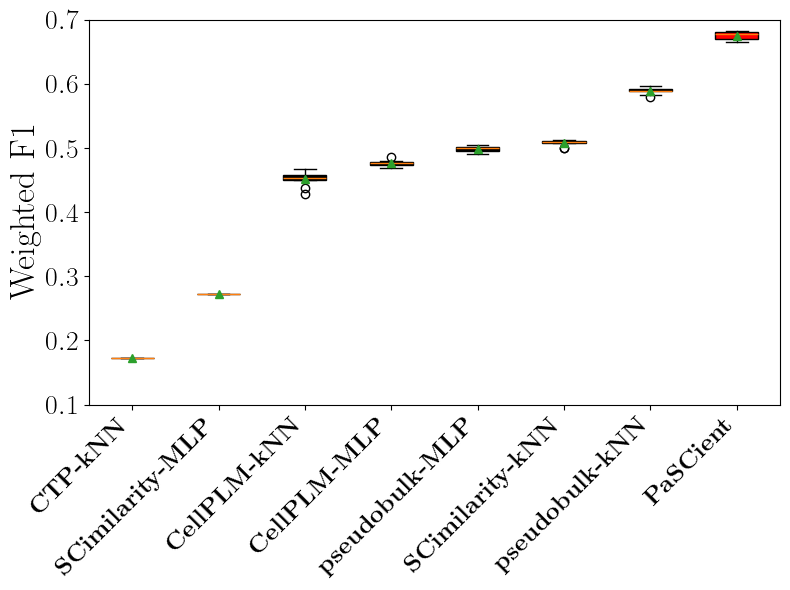

In [42]:
import random
import latex

plt.rcParams['text.usetex'] = True

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": r"\usepackage{amsmath}"
})

random.seed(2020)
def random_color():
    return (random.random(), random.random(), random.random())

pd_plot = df.parse('overall_compare_new')
pd_plot = pd_plot[['SCimilarity-MLP', 'pseudobulk-kNN', 'CellPLM-kNN',
       'CellPLM-MLP', 'pseudobulk-MLP', 'SCimilarity-kNN', 'PaSCient', 'CTP-kNN']]
# pd_plot = pd_plot[pd_plot['metric'] == 'f1']
# pd_plot = pd_plot.loc[:, pd_plot.columns != 'metric']
column_means = pd_plot.mean()
# Sort the means
sorted_means = column_means.sort_values()
# Optionally, get the rank of each column based on the mean
ranked_columns = sorted_means.rank()

fig, ax = plt.subplots(figsize=(8,6))

ax.set_ylabel('Weighted F1', fontsize=25)

pd_plot = pd_plot[ranked_columns.index]
colors = [method_color[i] for i in pd_plot.columns]
bplot = ax.boxplot(pd_plot,
                   patch_artist=True,  # fill with color
                   tick_labels=pd_plot.columns, showmeans=True)  # will be used to label x-ticks
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# mean_of_means = 0.2639
# ax.axhline(y=mean_of_means, color='gray', linestyle='--', linewidth=1.5, label=f'Mean: {mean_of_means:.2f}')
# ax.legend()
ax.set_ylim(0.1, 0.7)

labels = [r"\textbf{" + x.get_text()+"}" for x in ax.get_xticklabels()]
ax.set_xticklabels(labels = labels, fontsize = 18)#ax.get_xticklabels(), fontsize=19)
plt.yticks(fontsize=20)
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
plt.savefig("./figures/weightedf1_multilabel.pdf")
plt.show()


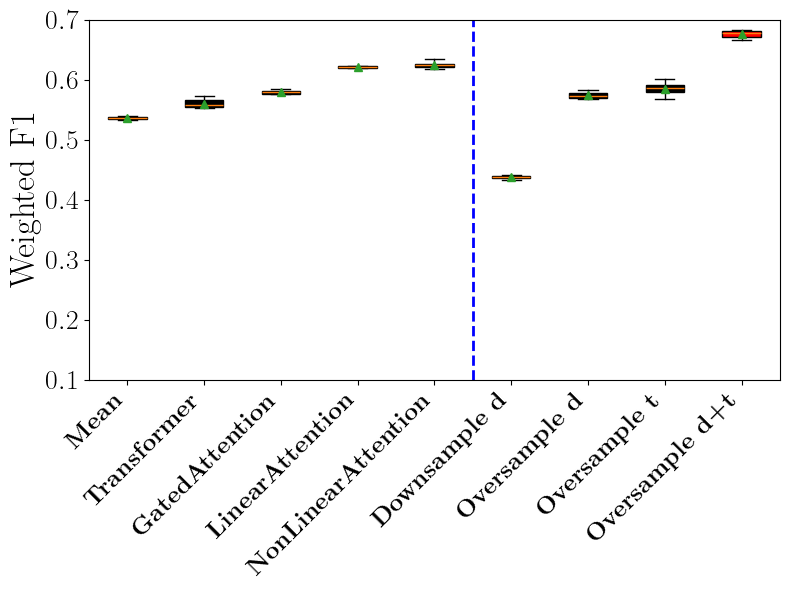

In [43]:
import random
random.seed(2020)
def random_color():
    return (random.random(), random.random(), random.random())

pd_plot = df.parse('overall_compare_new')
pd_plot = pd_plot[[
        'Mean', 'Transformer','GatedAttention','LinearAttention', 'NonLinearAttention', 'Downsample d', 'Oversample d',  'Oversample t', 'Oversample d+t']]
# # pd_plot = pd_plot[pd_plot['metric'] == 'f1']
# # pd_plot = pd_plot.loc[:, pd_plot.columns != 'metric']
# column_means = pd_plot.mean()
# # Sort the means
# sorted_means = column_means.sort_values()
# # Optionally, get the rank of each column based on the mean
# ranked_columns = sorted_means.rank()

# ranked_columns = [
#        'transformer', 'mean', 'gated_attn','linear_attn', 'nonlinear_attn', 'downsample d', 'oversample d',  'oversample t', 'oversample d+t']

fig, ax = plt.subplots(figsize=(8,6))

ax.set_ylabel('Weighted F1', fontsize=25)
method_color['Oversample d+t'] = method_color['PaSCient']
# pd_plot = pd_plot[ranked_columns.index]
colors = [method_color[i] for i in pd_plot.columns]
bplot = ax.boxplot(pd_plot,
                   patch_artist=True,  # fill with color
                   tick_labels=pd_plot.columns, showmeans=True)  # will be used to label x-ticks
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.axvline(x=5.5, color='blue', linestyle='--', lw=2)
#ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize=18)
labels = [r"\textbf{" + x.get_text()+"}" for x in ax.get_xticklabels()]
ax.set_xticklabels(labels = labels, fontsize = 18)#ax.get_xticklabels(), fontsize=19)
plt.yticks(fontsize=20)
plt.xticks(rotation=45, ha = 'right')
ax.set_ylim(0.1, 0.7)
plt.tight_layout()
plt.savefig("./figures/weightedf1_differentpolicy.pdf")
plt.show()
